In [3]:
import nflgame
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

np.random.seed(7)

# Get Data

In [4]:
# NFL Games for 2016
games = nflgame.games(2016)

In [5]:
players = nflgame.combine_game_stats(games)

In [6]:
# Get the Top 50 players who have the most rushing yards from the 2016 season
top50 = []
for p in players.rushing().sort('rushing_yds').limit(25):
    top50.append(p)

In [7]:
# Build DataFrame - Index for Player name and week #
top50_names = [str(p.name) for p in top50]
wks = range(1,18)
idxs = [top50_names, wks]

idx = pd.MultiIndex.from_product(idxs, names=['name', 'week'])
columns = [
    'rushing_att', 
    'rushing_yds', 
    'rushing_tds', 
    'fumbles_tot',
    'home',
    'DNP',
    'fantasy_points'
]
df = pd.DataFrame(data=None, index=idx, columns=columns)

In [8]:
df.head()

rushing_att rushing_yds rushing_tds fumbles_tot home  DNP  \
name      week                                                             
E.Elliott 1            NaN         NaN         NaN         NaN  NaN  NaN   
          2            NaN         NaN         NaN         NaN  NaN  NaN   
          3            NaN         NaN         NaN         NaN  NaN  NaN   
          4            NaN         NaN         NaN         NaN  NaN  NaN   
          5            NaN         NaN         NaN         NaN  NaN  NaN   

               fantasy_points  
name      week                 
E.Elliott 1               NaN  
          2               NaN  
          3               NaN  
          4               NaN  
          5               NaN

In [9]:
# Update DF with stats for Top 50 players for all games
for g in games:
    wk = g.schedule['week']
    for p in g.players.rushing():
        
        # Check if top50 player
        if p.name in df.index:
            df.loc[(p.name, wk), 'rushing_att'] = p.rushing_att
            df.loc[(p.name, wk), 'rushing_yds'] = p.rushing_yds
            df.loc[(p.name, wk), 'rushing_tds'] = p.rushing_tds
            df.loc[(p.name, wk), 'fumbles_tot'] = p.fumbles_tot
            df.loc[(p.name, wk), 'home'] = p.home

In [10]:
# Calculate Fantasy Points
df['fantasy_points'] = df['rushing_yds'] * .1 + df['rushing_tds'] * 6 - df['fumbles_tot'] * 2

In [11]:
# DNP
df.loc[df['fantasy_points'].isnull(), 'DNP'] = True
df.loc[df['fantasy_points'].notnull(), 'DNP'] = False

# Fill NaNs
df = df.fillna(0)

# Boolean Values to int
df['home'] = df['home'].astype('int')
df['DNP'] = df['DNP'].astype('int')

In [308]:
df

rushing_att  rushing_yds  rushing_tds  fumbles_tot  home  DNP  \
name      week                                                                  
E.Elliott 1              20           51            1            0     1    1   
          2              21           83            1            2     0    1   
          3              30          140            0            0     1    1   
          4              23          138            1            0     0    1   
          5              15          134            2            0     1    1   
          6              28          157            0            0     0    1   
          7               0            0            0            0     0    1   
          8              22           96            0            0     1    1   
          9              18           92            2            1     0    1   
          10             21          114            2            0     0    1   
          11             25           97            0            0     1    1   
          12             20           97            2            0     1    1   
          13             20           86            1            1     0    1   
          14             24          107            0            0     0    1   
          15             23          159            1            1     1    1   
          16             12           80            2            0     1    1   
          17              0            0            0            0     0    1   
J.Howard  1               0            0            0            0     0    1   
          2               3           22            0            0     1    1   
          3               9           45            0            1     0    1   
          4              23          111            0            0     1    1   
          5              16          118            0            0     0    1   
          6              15           34            1            0     1    1   
          7               7           22            0            0     0    1   
          8              26          153            1            0     1    1   
          9               0            0            0            0     0    1   
          10             15          100            0            1     0    1   
          11             17           77            0            0     0    1   
          12             18           84            0            0     1    1   
          13             32          117            3            0     1    1   
...                     ...          ...          ...          ...   ...  ...   
R.Kelley  5               3           18            0            0     0    1   
          6               5           59            0            0     1    1   
          7               4           15            0            0     0    1   
          8              21           87            1            0     0    1   
          9               0            0            0            0     0    1   
          10             22           97            0            0     1    1   
          11             24          137            3            0     1    1   
          12             14           37            0            0     0    1   
          13             14           63            0            0     0    1   
          14             16           63            1            0     0    1   
          15              9            8            1            0     1    1   
          16             19           76            0            0     0    1   
          17             12           33            0            0     1    1   
R.Mathews 1              22           77            1            0     1    1   
          2               9           32            2            0     0    1   
          3               2           -5            0            0     1    1   
          4               0            0       

# Train Test Split

In [309]:
def create_dataset(dataset, games_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - games_back - 1):
        a = dataset[i:(i + games_back), :]
        dataX.append(a)
        
        # Last Game's fantasy points
        dataY.append(dataset[i + games_back, -1])
    return np.array(dataX), np.array(dataY)

In [310]:
def build_dataset(df, games_back):
    X = np.array([])
    Y = np.array([])
    for player in set(df.index.get_level_values(0)):
        data = df.loc[player].values
        X_, Y_ = create_dataset(data, games_back=games_back)
        if len(X) == 0 and len(Y) == 0:
            X = X_
            Y = Y_
        else:
            X = np.append(X, X_, axis=0)
            Y = np.append(Y, Y_, axis=0)
    return X, Y

In [327]:
def train_test_split(X, Y):
    # Shuffle Data
    idxs_shuffled = np.random.permutation(len(Y))
    X_shuffled = X[idxs_shuffled]
    Y_shuffled = Y[idxs_shuffled]
    
    # Train / Test Split
    split = .67
    train_sizeX = int(len(X) * split)
    train_sizeY = int(len(Y) * split)
    test_sizeX = int(len(X) * (1 - split))
    test_sizeY = int(len(Y) * (1 - split))

    trainX = X_shuffled[:train_sizeX]
    trainY = Y_shuffled[:train_sizeY]
    testX = X_shuffled[train_sizeX:]
    testY = Y_shuffled[train_sizeY:]
    
    return trainX, trainY, testX, testY

In [328]:
games_back = 3
X, Y = build_dataset(df, games_back)
trainX, trainY, testX, testY = train_test_split(X, Y)

# Build Model

In [324]:
def build_model(df):
    column_nums = len(df.columns)
    model = Sequential()
    model.add(LSTM(10, input_dim=column_nums))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [325]:
model = build_model(df)

/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(None, 7))`
  after removing the cwd from sys.path.


# Train Model

In [315]:
model.fit(trainX, trainY, nb_epoch=30, batch_size=1, verbose=2)

Epoch 1/60
2s - loss: 116.8139
Epoch 2/60
1s - loss: 106.2454
Epoch 3/60
2s - loss: 96.9028
Epoch 4/60
2s - loss: 82.6383
Epoch 5/60
2s - loss: 71.3209
Epoch 6/60
1s - loss: 63.6830
Epoch 7/60
2s - loss: 60.7471
Epoch 8/60
2s - loss: 59.1967
Epoch 9/60
2s - loss: 58.0456
Epoch 10/60
1s - loss: 56.9613
Epoch 11/60
1s - loss: 56.1206
Epoch 12/60
1s - loss: 55.5109
Epoch 13/60
2s - loss: 55.0630
Epoch 14/60
2s - loss: 54.5954
Epoch 15/60
1s - loss: 54.1917
Epoch 16/60
1s - loss: 53.7991
Epoch 17/60
1s - loss: 53.5172
Epoch 18/60
2s - loss: 53.3862
Epoch 19/60
2s - loss: 52.9263
Epoch 20/60
1s - loss: 52.7020
Epoch 21/60
1s - loss: 52.4310
Epoch 22/60
1s - loss: 52.3366
Epoch 23/60
2s - loss: 52.0720
Epoch 24/60
2s - loss: 51.9667
Epoch 25/60
1s - loss: 51.7400
Epoch 26/60
1s - loss: 51.6956
Epoch 27/60
1s - loss: 51.4277
Epoch 28/60
2s - loss: 51.3797
Epoch 29/60
2s - loss: 51.3101
Epoch 30/60
1s - loss: 51.2965
Epoch 31/60
1s - loss: 51.3702
Epoch 32/60
1s - loss: 50.9552
Epoch 33/60
2s 

# Analyze Model

In [316]:
# Train Score
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore

6.9568186643651595

In [317]:
# Test Score
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore

8.59629001880476

In [318]:
# Predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [319]:
def plotPlayerPredictions(df, games_back=4, model=None, player=''):
    X_, Y_ = create_dataset(df.values, games_back=games_back)
    
    if model:
        Y_pred = model.predict(X_)
        # Prepend Prediction with 0's for games not predicted
        Y = np.insert(Y_pred, 0, values=[0] * games_back)
        plt.gca().set_ylim([0,40])
        plt.title(player)
        plt.plot(df['fantasy_points'].values)
        plt.plot(Y)
        plt.show()
        

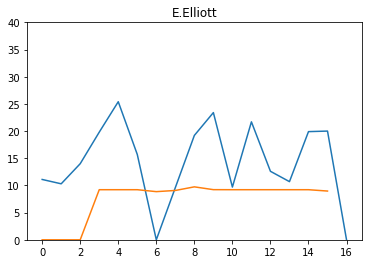

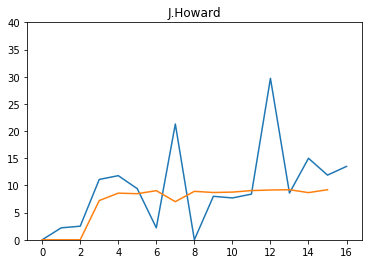

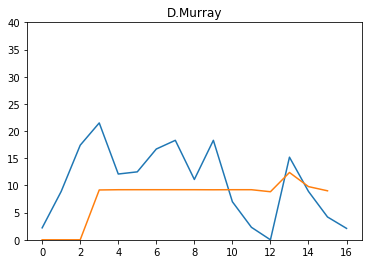

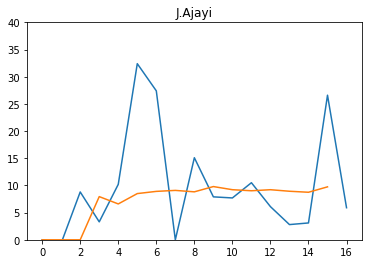

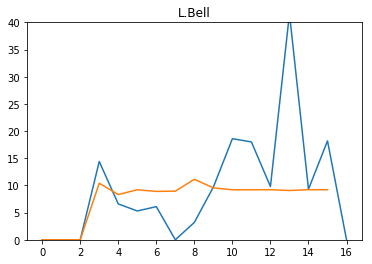

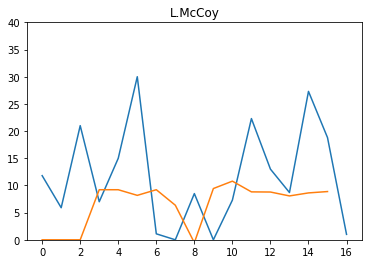

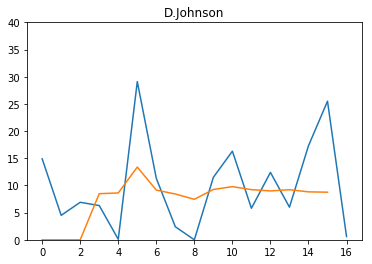

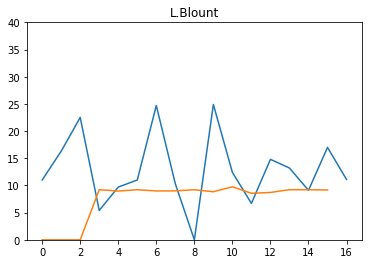

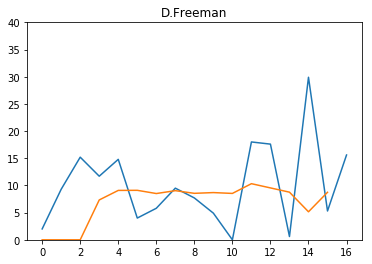

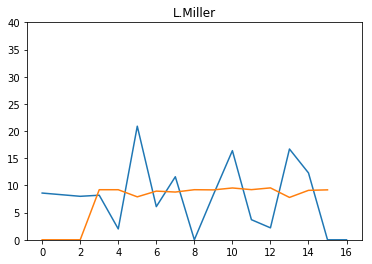

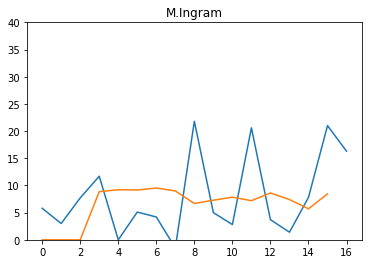

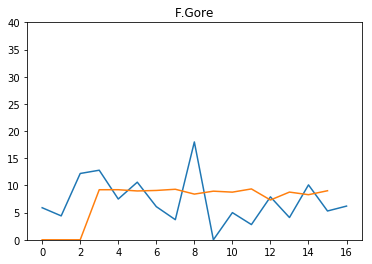

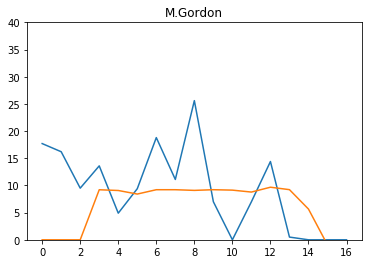

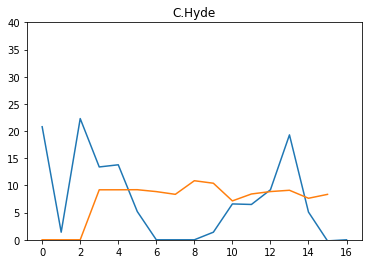

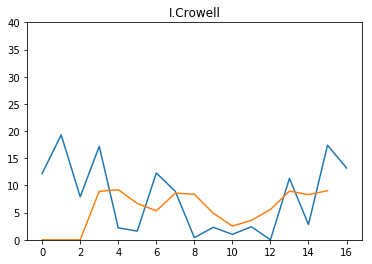

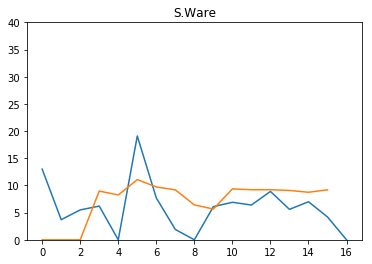

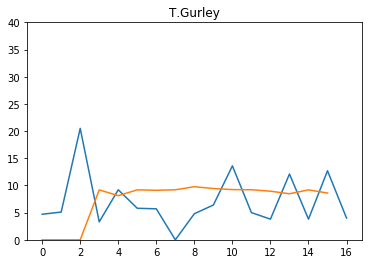

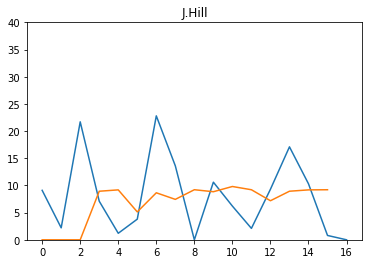

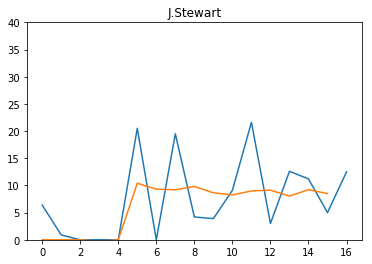

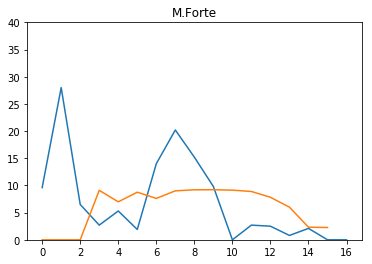

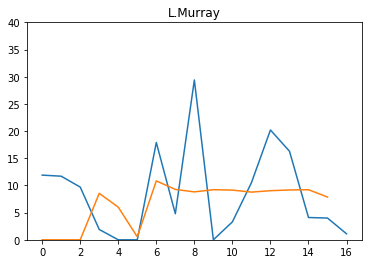

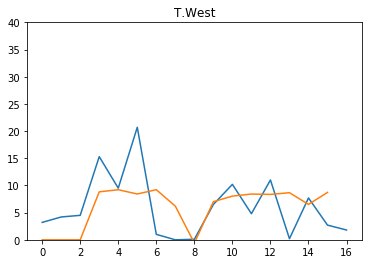

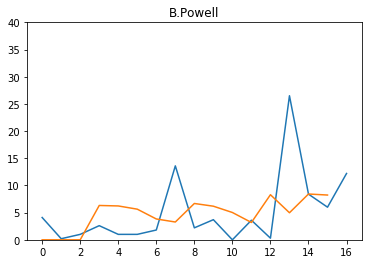

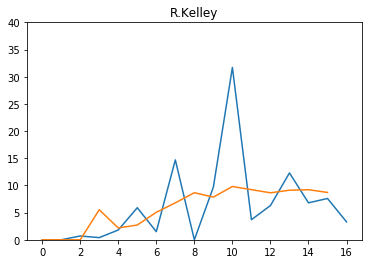

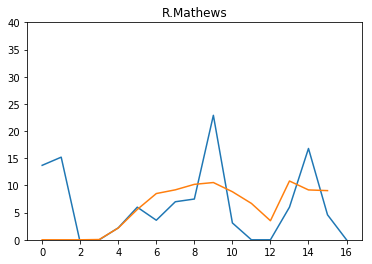

In [323]:
for p in top50_names:
    plotPlayerPredictions(df.loc[p], games_back=games_back, model=model, player=p)

# Best Number of Games for Prediction

In [341]:
num_games = 16
models = []
columns_results = ['games back', 'train score', 'test score']
df_results = pd.DataFrame([], columns=columns_results)
for num_games_back in range(1, num_games):
    X, Y = build_dataset(df, games_back=num_games_back)
    trainX, trainY, testX, testY = train_test_split(X, Y)
    model = build_model(df)
    model.fit(trainX, trainY, nb_epoch=30, batch_size=1, verbose=2)
    models.append(model)
    
    # Train Score
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    trainScore = math.sqrt(trainScore)

    # Test Score
    testScore = model.evaluate(testX, testY, verbose=0)
    testScore = math.sqrt(testScore)
    
    # Save Results
    result = [num_games_back, trainScore, testScore]
    df_result = pd.DataFrame([result], columns=columns_results)
    df_results = df_results.append(df_result)

/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(None, 7))`
  after removing the cwd from sys.path.


Epoch 1/30
2s - loss: 133.3543
Epoch 2/30
1s - loss: 106.1124
Epoch 3/30
1s - loss: 92.5154
Epoch 4/30
1s - loss: 84.8006
Epoch 5/30
1s - loss: 78.7157
Epoch 6/30
1s - loss: 73.8758
Epoch 7/30
1s - loss: 70.0333
Epoch 8/30
1s - loss: 65.4797
Epoch 9/30
1s - loss: 62.5312
Epoch 10/30
1s - loss: 61.0890
Epoch 11/30
1s - loss: 60.0777
Epoch 12/30
1s - loss: 59.4235
Epoch 13/30
1s - loss: 58.9175
Epoch 14/30
1s - loss: 58.4454
Epoch 15/30
1s - loss: 58.1502
Epoch 16/30
1s - loss: 58.1638
Epoch 17/30
1s - loss: 57.8567
Epoch 18/30
1s - loss: 57.5743
Epoch 19/30
1s - loss: 57.5523
Epoch 20/30
1s - loss: 57.4319
Epoch 21/30
1s - loss: 57.2768
Epoch 22/30
1s - loss: 57.1542
Epoch 23/30
1s - loss: 57.1943
Epoch 24/30
1s - loss: 56.9983
Epoch 25/30
1s - loss: 56.8804
Epoch 26/30
1s - loss: 56.9356
Epoch 27/30
1s - loss: 56.8553
Epoch 28/30
1s - loss: 56.6644
Epoch 29/30
1s - loss: 56.6601
Epoch 30/30
1s - loss: 58.1082
Epoch 1/30
2s - loss: 130.5408
Epoch 2/30
1s - loss: 108.0675
Epoch 3/30
1s -

2s - loss: 52.3679
Epoch 28/30
2s - loss: 52.1850
Epoch 29/30
2s - loss: 51.8452
Epoch 30/30
2s - loss: 51.6914
Epoch 1/30
3s - loss: 148.6985
Epoch 2/30
2s - loss: 119.9843
Epoch 3/30
2s - loss: 102.9308
Epoch 4/30
2s - loss: 94.9655
Epoch 5/30
2s - loss: 85.1407
Epoch 6/30
2s - loss: 78.1985
Epoch 7/30
2s - loss: 74.7125
Epoch 8/30
2s - loss: 71.4704
Epoch 9/30
2s - loss: 69.2243
Epoch 10/30
2s - loss: 67.7579
Epoch 11/30
2s - loss: 66.5579
Epoch 12/30
2s - loss: 65.4335
Epoch 13/30
2s - loss: 64.5690
Epoch 14/30
2s - loss: 63.7312
Epoch 15/30
2s - loss: 63.0777
Epoch 16/30
2s - loss: 62.5899
Epoch 17/30
2s - loss: 62.2119
Epoch 18/30
2s - loss: 61.7812
Epoch 19/30
2s - loss: 61.2973
Epoch 20/30
2s - loss: 60.8798
Epoch 21/30
2s - loss: 60.5759
Epoch 22/30
2s - loss: 60.4365
Epoch 23/30
2s - loss: 60.2298
Epoch 24/30
2s - loss: 59.8388
Epoch 25/30
2s - loss: 59.7072
Epoch 26/30
2s - loss: 59.6458
Epoch 27/30
2s - loss: 59.1640
Epoch 28/30
2s - loss: 59.4246
Epoch 29/30
2s - loss: 59.

In [342]:
df_results

,games back,train score,test score
0,1,7.558050,7.929606
0,2,7.624607,7.697109
0,3,7.210239,8.472538
0,4,7.987545,7.445365
0,5,7.052177,9.765583
0,6,7.517332,8.109748
0,7,7.424337,8.389363
0,8,8.049691,6.586254
0,9,7.156389,8.147170
0,10,7.625821,7.104837


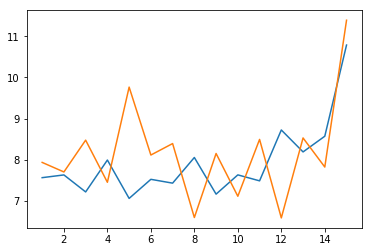

In [345]:
plt.plot(df_results.set_index('games back'))
plt.show()